In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [53]:
if torch.cuda.is_available():
    device = "cuda:0"
    
model_dir = '/neurospin/dico/lguillon/distmap/pre_post_ambiguity_search/n_150_bsize_8_kl_1_v6/checkpoint.pt'
#model_dir = '/neurospin/dico/lguillon/distmap/checkpoint.pt'
model = VAE((1, 80, 80, 96), 150, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [3]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))

In [4]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [5]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
subjects_name_hcp = ['' for k in range(200)] + list(df_encoded_hcp[-7:]['sub'])

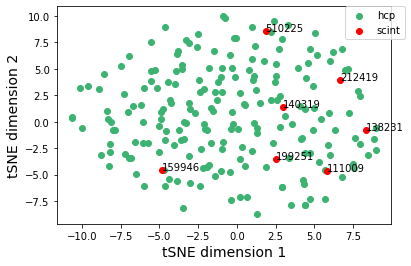

In [6]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [8]:
df_encoded_hcp['latent'][175]

array([ 2.4287229e+00,  9.1864610e-01,  1.3817806e+00, -1.7014818e+00,
        7.8640550e-01,  7.1760535e-01, -1.7038701e+00,  2.2088066e-01,
       -2.7567756e+00, -2.6345453e-01, -2.1878269e-01, -8.7773430e-01,
        1.7491435e-01,  1.6983638e+00,  1.6407160e-01,  2.2672458e+00,
       -2.4602060e+00,  2.4457350e-01,  8.3437210e-01, -1.4328322e+00,
       -1.5247579e-01,  5.6363136e-01, -2.8544438e-01, -1.0813529e+00,
        1.6056273e+00, -1.8105919e+00,  4.5422328e-01,  1.0814204e+00,
       -1.0377508e+00,  5.6735522e-01, -1.4586190e+00,  2.9412559e-01,
       -1.8630607e+00,  6.9745654e-01,  2.2000473e+00,  4.7853157e-01,
       -2.0620286e+00, -1.3084512e+00, -1.2234845e+00, -1.2878735e+00,
        9.6365482e-01,  4.2861957e-02, -2.0523715e+00, -1.6638201e+00,
       -7.8012519e-02,  9.1511220e-01,  1.0537411e+00,  1.6767716e+00,
       -1.0315847e+00, -1.1308869e+00,  6.0876781e-01,  2.0734856e+00,
       -1.5312744e+00, -2.1818106e+00,  1.1906798e+00,  1.7735783e+00,
      

In [22]:
enc = df_encoded_hcp['latent'][175]

z = torch.from_numpy(enc).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
#error_map = df_encoded_hcp['input'][k_centroid] - out

#np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_out.npy", out)
#np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_input.npy', df_encoded_hcp['input'][k_centroid])
#np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_error.npy', error_map)

In [17]:
z.shape

torch.Size([1, 75])

In [23]:
out.shape

(80, 80, 96)

In [24]:
np.unique(out)

array([-0.5806439 , -0.5405922 , -0.51359946, ...,  1.3465338 ,
        1.4279237 ,  1.7253451 ], dtype=float32)

In [72]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/lguillon/distmap/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

""" SC INT """
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps_scint = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_scint = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders_hcp = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=1,
                     n_latent=150, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}


(200, 78, 63, 88, 1) (200,)
(7, 78, 63, 88, 1) (7,)
hcp
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9908316e-01 9.9935913e-01
 9.9955142e-01]
[0.0000000e+00 1.6450882e-05 1.6689301e-05 ... 9.9897456e-01 9.9975324e-01
 9.9990916e-01]
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9955142e-01 9.9978638e-01
 9.9981844e-01]
[0.000000e+00 9.083748e-05 9.703636e-05 ... 9.985260e-01 9.986541e-01
 9.996475e-01]
[0.0000000e+00 7.6055527e-05 9.8228455e-05 ... 9.9942851e-01 9.9949801e-01
 9.9971688e-01]
[0.0000000e+00 1.4615059e-04 1.6379356e-04 ... 9.9816823e-01 9.9860609e-01
 9.9962616e-01]
[0.0000000e+00 2.2602081e-04 2.8586388e-04 ... 9.9940193e-01 9.9955142e-01
 9.9978101e-01]
[0.0000000e+00 1.4781952e-05 2.1696091e-05 ... 9.9865413e-01 9.9966359e-01
 9.9985051e-01]
[0.0000000e+00 1.3113022e-05 1.7404556e-05 ... 9.9923635e-01 9.9955666e-01
 9.9983978e-01]
[0.0000000e+00 2.1934509e-05 2.4080276e-05 ... 9.9927366e-01 9.9936450e-01
 9.9996257e-01]
[0.0000000e+00 5.3167343e-05 5.7458878e-

[0.0000000e+00 2.5987625e-05 2.6941299e-05 ... 9.9901199e-01 9.9920428e-01
 9.9951935e-01]
[0.0000000e+00 1.2707710e-04 1.3875961e-04 ... 9.9887848e-01 9.9910271e-01
 9.9998391e-01]
[0.0000000e+00 5.0067902e-06 5.4836273e-06 ... 9.9881434e-01 9.9892294e-01
 9.9936831e-01]
[0.0000000e+00 3.5524368e-05 4.1484833e-05 ... 9.9960482e-01 9.9981844e-01
 9.9989319e-01]
[0.000000e+00 8.201599e-05 9.179115e-05 ... 9.990387e-01 9.992310e-01
 9.993217e-01]
[0.0000000e+00 2.3841858e-06 2.6226044e-06 ... 9.9918818e-01 9.9920428e-01
 9.9954069e-01]
[0.0000000e+00 1.1110306e-04 1.1730194e-04 ... 9.9958348e-01 9.9961555e-01
 9.9996793e-01]
[0.0000000e+00 3.1232834e-05 3.7670135e-05 ... 9.9933779e-01 9.9946070e-01
 9.9995029e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9916685e-01 9.9967957e-01
 9.9984515e-01]
[0.0000000e+00 1.8763542e-04 2.4390221e-04 ... 9.9985051e-01 9.9991453e-01
 9.9999464e-01]
[0.00000000e+00 1.11579895e-04 1.21831894e-04 ... 9.99343038e-01
 9.99444604e-01 9.99658227e-01]

[0.0000000e+00 2.2649765e-05 3.0279160e-05 ... 9.9986744e-01 9.9990392e-01
 9.9994659e-01]
[0.0000000e+00 1.5521049e-04 1.7857552e-04 ... 9.9793851e-01 9.9977577e-01
 9.9990392e-01]
[0.0000000e+00 2.3365021e-05 3.0994415e-05 ... 9.9883580e-01 9.9902797e-01
 9.9974358e-01]
[0.0000000e+00 1.1920929e-04 1.4948845e-04 ... 9.9918818e-01 9.9939656e-01
 9.9943388e-01]
[0.0000000e+00 2.2411346e-05 2.3365021e-05 ... 9.9909210e-01 9.9923635e-01
 9.9987185e-01]
[0.0000000e+00 1.2898445e-04 1.5664101e-04 ... 9.9838710e-01 9.9986112e-01
 9.9992526e-01]
[0.0000000e+00 1.2493134e-04 1.6164780e-04 ... 9.9956203e-01 9.9983442e-01
 9.9998415e-01]
[0.0000000e+00 3.6716461e-05 4.2676926e-05 ... 9.9940944e-01 9.9952567e-01
 9.9968493e-01]
[0.0000000e+00 1.6689301e-04 2.3555756e-04 ... 9.9765015e-01 9.9851000e-01
 9.9959159e-01]
[0.0000000e+00 2.7179718e-05 2.9563904e-05 ... 9.9871826e-01 9.9944985e-01
 9.9948204e-01]
[0.0000000e+00 4.4822693e-05 4.9829483e-05 ... 9.9837840e-01 9.9865746e-01
 9.9886596e-01]

In [54]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps_scint = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_scint = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders_hcp = {'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=1,
                     n_latent=150, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

(7, 78, 63, 88, 1) (7,)
scint
[0.0000000e+00 2.0742416e-05 3.2901764e-05 ... 9.9946594e-01 9.9947131e-01
 9.9949801e-01]
[0.0000000e+00 3.0994415e-06 4.0531158e-06 ... 9.9826968e-01 9.9914551e-01
 9.9953008e-01]
[0.0000000e+00 9.3936920e-05 1.0442734e-04 ... 9.9919891e-01 9.9944985e-01
 9.9973822e-01]
[0.0000000e+00 8.6069107e-05 9.0122223e-05 ... 9.9916887e-01 9.9929404e-01
 9.9999464e-01]
[0.000000e+00 3.337860e-05 3.528595e-05 ... 9.994670e-01 9.995514e-01
 9.996742e-01]
[0.0000000e+00 5.9127808e-05 6.3657761e-05 ... 9.9829638e-01 9.9859536e-01
 9.9939120e-01]
[0.0000000e+00 9.9420547e-05 1.2373924e-04 ... 9.9951279e-01 9.9979711e-01
 9.9989557e-01]


In [74]:
X_hcp.shape

(207, 150)

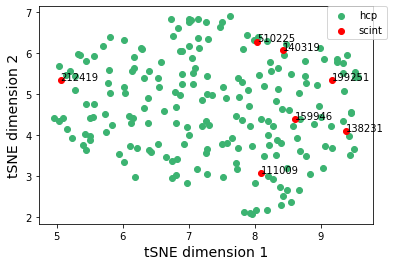

In [86]:
X_hcp = np.array(encoded_hcp['hcp'] + encoded_hcp['scint'])
labels_hcp = np.array(['hcp' for k in range(200)] + ['scint' for k in range(7)])

reducer = umap.UMAP()
X_embedded_hcp = reducer.fit_transform(X_hcp)

arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [87]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

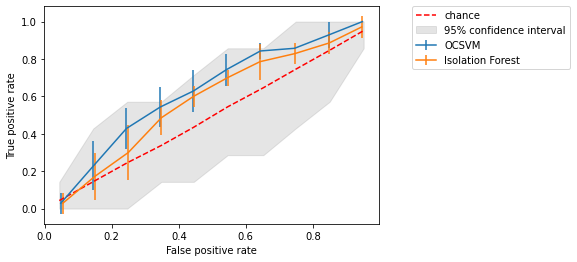

In [88]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

(array([1., 0., 2., 1., 1., 0., 0., 1., 0., 1.]),
 array([1628. , 1697.5, 1767. , 1836.5, 1906. , 1975.5, 2045. , 2114.5,
        2184. , 2253.5, 2323. ]),
 <BarContainer object of 10 artists>)

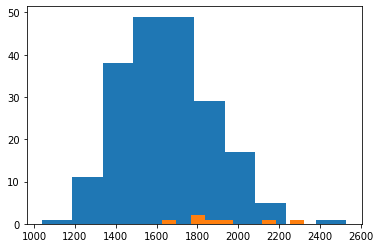

In [89]:
plt.subplot()
plt.hist(losses_hcp['hcp'])
plt.hist(losses_hcp['scint'])

In [90]:
F,p = mannwhitneyu(losses_hcp['hcp'], losses_hcp['scint'])
print(p)

0.00181860208036109


In [32]:
enc = encoded_hcp['scint'][0]

In [50]:
z = torch.from_numpy(enc).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0
out = dtx.convert.volume_to_bucketMap_aims(out, voxel_size=(1,1,1))

aims.write(out, f"/tmp/test.bck")

In [51]:
k_openKnob = int(np.where(df_encoded_hcp['sub']==611938)[0])

In [52]:
enc = df_encoded_hcp['latent'][k_openKnob]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
out[out>0.5] = 1
out[out<=0.5] = 0
#aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/open_knob.bck")
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/tmp/open_knob.bck")

In [45]:
np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/through_latent_space/centroid_out.npy", out)